In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, concatenate
from keras.layers import GaussianDropout, GaussianNoise
from keras.layers import GRU, Bidirectional, TimeDistributed
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import os
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\covin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# DATASET
DATASET_COLUMNS = ["target", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S"

# WORD2VEC
W2V_WINDOW = 7
W2V_EPOCH = 32

MAXLEN = 100
MAX_SENTENCES = 15
MAX_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [18]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

# class defining the custom attention layer
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim=100, **kwargs):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]
    
    def get_config(self):
        config = {'supports_masking': self.supports_masking, 'attention_dim': self.attention_dim}
        base_config = super(HierarchicalAttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
df_train = pd.read_csv("yelp2015/train.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df_test = pd.read_csv("yelp2015/test.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [22]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [3]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [10]:
%%time
df_train.text = df_train.text.apply(lambda x: preprocess(x))
df_test.text = df_test.text.apply(lambda x: preprocess(x))

Wall time: 2min 48s


In [11]:
decode_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
def decode_sentiment(label):
    return decode_map[int(label)]

In [12]:
%%time
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))

Wall time: 394 ms


In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\covin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
from nltk import tokenize

reviews = []
labels = []
texts = []

for idx, _ in df_train.iterrows():
    text = df_train.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_train.target[idx])

TRAIN_SIZE = len(texts)

for idx, _ in df_test.iterrows():
    text = df_test.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_test.target[idx])

In [15]:
from keras.preprocessing.text import text_to_word_sequence

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTENCES:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 274079 unique tokens.


In [16]:
from keras.utils.np_utils import to_categorical

labels = to_categorical(np.asarray(labels))
print('Shape of reviews (data) tensor:', data.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

Shape of reviews (data) tensor: (700000, 15, 100)
Shape of sentiment (label) tensor: (700000, 5)


In [17]:
x_train = data[:TRAIN_SIZE]
y_train = labels[:TRAIN_SIZE]
x_test = data[TRAIN_SIZE:]
y_test = labels[TRAIN_SIZE:]

In [26]:
embeddings_index = {}

f = open("glove/glove.6B.100d.txt", encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [27]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAXLEN, trainable=True, mask_zero=True)

In [28]:
sentence_input = Input(shape=(MAXLEN,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
attn_word = HierarchicalAttentionNetwork(100)(lstm_word)
sentenceEncoder = Model(sentence_input, attn_word)

review_input = Input(shape=(MAX_SENTENCES, MAXLEN), dtype='int32')
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
preds = Dense(5, activation='softmax')(attn_sentence)
model = Model(review_input, preds)

tracking <tf.Variable 'hierarchical_attention_network_3/Variable:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_3/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_3/Variable_2:0' shape=(100, 1) dtype=float32> u
tracking <tf.Variable 'hierarchical_attention_network_4/Variable:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_4/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_4/Variable_2:0' shape=(100, 1) dtype=float32> u


In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [30]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 200)           27548800  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 15, 200)           180600    
_________________________________________________________________
hierarchical_attention_netwo (None, 200)               20200     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1005      
Total params: 27,750,605
Trainable params: 27,750,605
Non-trainable params: 0
_________________________________________________________________


In [31]:
print("model fitting - Hierachical attention network")
history = model.fit(x_train, y_train, validation_split=0.2, nb_epoch=10, batch_size=64)

model fitting - Hierachical attention network


C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 520000 samples, validate on 130000 samples
Epoch 1/10
520000/520000 [==============================] - 5776s 11ms/step - loss: 0.9256 - acc: 0.5943 - val_loss: 0.8087 - val_acc: 0.6516
Epoch 2/10
520000/520000 [==============================] - 5888s 11ms/step - loss: 0.8192 - acc: 0.6435 - val_loss: 0.7952 - val_acc: 0.6571
Epoch 3/10
520000/520000 [==============================] - 5944s 11ms/step - loss: 0.7601 - acc: 0.6710 - val_loss: 0.7861 - val_acc: 0.6647
Epoch 4/10
520000/520000 [==============================] - 6043s 12ms/step - loss: 0.6966 - acc: 0.7014 - val_loss: 0.8267 - val_acc: 0.6552
Epoch 5/10
520000/520000 [==============================] - 6054s 12ms/step - loss: 0.6242 - acc: 0.7358 - val_loss: 0.8897 - val_acc: 0.6439
Epoch 6/10
520000/520000 [==============================] - 6026s 12ms/step - loss: 0.5465 - acc: 0.7726 - val_loss: 0.9705 - val_acc: 0.6362
Epoch 7/10
520000/520000 [==============================] - 6031s 12ms/step - loss: 0.4719 - acc

In [32]:
%%time
score = model.evaluate(x_test, y_test, batch_size=100)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

50000/50000 [==============================] - 148s 3ms/step

ACCURACY: 0.5867199897766113
LOSS: 1.5937041273117065
Wall time: 2min 27s


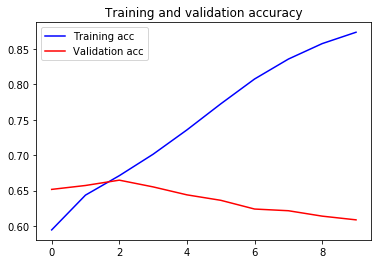

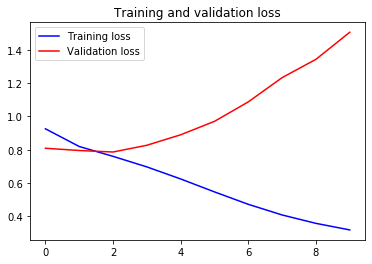

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [35]:
model.save("hatn_yelp2_modregex_glove.h5")
pickle.dump(tokenizer, open("tokenizer2_modregex_glove.pkl", "wb"), protocol=0)

In [19]:
from keras.models import load_model

model = load_model("hatn_yelp2_modregex_glove.h5", custom_objects={'HierarchicalAttentionNetwork':HierarchicalAttentionNetwork})
tokenizer = None
with open('tokenizer2_modregex_glove.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-05-03 08:50:05,423 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-05-03 08:50:05,677 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\tensorflow_core\python\keras\backend.py:3994: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


tracking <tf.Variable 'hierarchical_attention_network_3/Variable:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_3/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_3/Variable_2:0' shape=(100, 1) dtype=float32> u
tracking <tf.Variable 'hierarchical_attention_network_4/Variable:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_4/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_4/Variable_2:0' shape=(100, 1) dtype=float32> u



2020-05-03 08:50:13,986 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [20]:
from nltk import tokenize
from keras.preprocessing.text import text_to_word_sequence

def predict_new_text(text, model, tokenizer):
    text = preprocess(text)
    texts = []
    reviews = []
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)

    data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

    for i, sentences in enumerate(reviews):
        for j, sent in enumerate(sentences):
            if j < MAX_SENTENCES:
                wordTokens = text_to_word_sequence(sent)
                k = 0
                for _, word in enumerate(wordTokens):
                    if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1
                        
    ynew = model.predict(data)
    return ynew

In [23]:
text = "the restaurant we went yesterday was wonderful."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.00493948 0.00785835 0.03351106 0.39929214 0.55439895]]
5


In [24]:
text = "the restaurant we went yesterday was awful.\nThe food was bad, the service was bad."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[6.9148618e-01 2.9042530e-01 1.7682416e-02 4.0334216e-04 2.8390807e-06]]
1
